# Deep Unmixing Autoencoder (DAEU) - PyTorch Implementation

Implementation of

B. Palsson, J. Sigurdsson, J. R. Sveinsson and M. O. Ulfarsson, "Hyperspectral Unmixing Using a Neural Network Autoencoder," in IEEE Access, vol. 6, pp. 25646-25656, 2018, doi: 10.1109/ACCESS.2018.2818280.


## Imports


In [ ]:
%%capture
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.image import extract_patches_2d
from scipy import io as sio
import os
import numpy as np
from numpy.linalg import inv
import warnings
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
# %matplotlib inline
import datetime
import time
import os
import numpy as np
import scipy.io as sio


from unmixing_pytorch import HSI, plotEndmembers, SAD
from unmixing_pytorch import plotEndmembersAndGT, plotAbundancesSimple, load_HSI
from unmixing_pytorch import (
    plotEndmembersAndGTV2,
    plotAbundancesSimpleV2,
    plotAbundancesSimpleGT,
    plotTrainingHistory,
    plotTrainingHistoryV2,
)

from models import Autoencoder, BetaVAE

from trainer import SADLoss


# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
print(f"Using device: {device}")
# Dictonary of aliases for datasets. The first string is the key and second is value (name of matfile without .mat suffix)
# Useful when looping over datasets
datasetnames = {"Samson": "Samson"}

dataset = "Samson"

hsi = load_HSI("./Datasets/" + datasetnames[dataset] + ".mat")
data = hsi.array()

# Base hyperparameters
num_endmembers = 3  # Samson dataset typically has 3 endmembers
num_spectra = 9025  # Number of spectra to sample for training

print(f"Dataset: {dataset}")
print(f"Data shape: {data.shape}")
print(f"Number of bands: {hsi.bands}")
print(f"Number of endmembers: {num_endmembers}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~ START OF CORRECTED CODE BLOCK ~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def compute_reconstruction_rmse(hsi, abundances, endmembers):
    """
    Compute RMSE between original HSI image and reconstructed image from abundances and endmembers.

    Args:
        hsi: HSI object containing the original image
        abundances: Abundance maps of shape (height, width, num_endmembers) or (num_pixels, num_endmembers)
        endmembers: Endmember matrix of shape (num_endmembers, num_bands)

    Returns:
        float: RMSE value between original and reconstructed image
    """
    # Get original image
    original_image = hsi.image  # Shape: (height, width, bands)
    height, width, bands = original_image.shape

    # Reshape original image to (num_pixels, bands)
    original_reshaped = original_image.reshape(-1, bands)

    # Handle abundances shape
    if abundances.ndim == 3:
        # Shape: (height, width, num_endmembers) -> (num_pixels, num_endmembers)
        abundances_reshaped = abundances.reshape(-1, abundances.shape[2])
    else:
        # Already shape: (num_pixels, num_endmembers)
        abundances_reshaped = abundances

    # Reconstruct image: abundances @ endmembers
    # abundances: (num_pixels, num_endmembers)
    # endmembers: (num_endmembers, bands)
    # result: (num_pixels, bands)
    reconstructed = abundances_reshaped @ endmembers

    # Compute RMSE
    mse = np.mean((original_reshaped - reconstructed) ** 2)
    rmse = np.sqrt(mse)

    return rmse


import numpy as np
from numpy.linalg import norm
import warnings

try:
    from scipy.optimize import linear_sum_assignment
except ImportError:
    warnings.warn(
        "Scipy not installed. aSAM and aRMSE metrics will be unavailable. "
        "Please install it with: pip install scipy"
    )
    linear_sum_assignment = None


def _calculate_sam_degrees(v1, v2):
    """Calculates the Spectral Angle Mapper in degrees between two vectors."""
    # Clip to avoid numerical errors with arccos
    cos_angle = np.clip(np.dot(v1, v2) / (norm(v1) * norm(v2)), -1, 1)
    sam_rad = np.arccos(cos_angle)
    return np.rad2deg(sam_rad)


def compute_unmixing_metrics(hsi, estimated_abundances, estimated_endmembers):
    """
    Computes a suite of metrics to assess hyperspectral unmixing performance.

    This function calculates:
    1. Reconstruction RMSE: Error between the original image and the one reconstructed
       from the estimated abundances and endmembers.
    2. aSAM (average Spectral Angle Mapper): Compares the similarity between estimated
       and ground truth endmembers after finding the optimal permutation.
    3. aRMSE (average Root Mean Square Error): Compares the error between estimated
       and ground truth abundance maps after reordering based on the endmember matching.

    Args:
        hsi (object): An HSI object with the following attributes:
            - .image (np.ndarray): Original HSI data of shape (H, W, L).
            - .gt (np.ndarray): Ground truth endmembers of shape (P, L).
            - .abundances_map (np.ndarray): Ground truth abundances of shape (H, W, P).
        estimated_abundances (np.ndarray): Estimated abundances from the model.
            Can be shape (H, W, P) or (H*W, P).
        estimated_endmembers (np.ndarray): Estimated endmembers from the model, shape (P, L).

    Returns:
        dict: A dictionary containing the calculated metrics:
              'Reconstruction_RMSE', 'aSAM_degrees', 'Abundance_aRMSE'.
    """
    # --- 1. Data Preparation ---
    # Reshape all data to 2D arrays (num_pixels, features) for consistency
    original_image = hsi.image
    H, W, L = original_image.shape
    P = estimated_endmembers.shape[0]  # Number of endmembers

    original_pixels = original_image.reshape(-1, L)
    estimated_abun_pixels = estimated_abundances.reshape(-1, P)

    gt_endmembers = hsi.gt
    gt_abun_pixels = hsi.abundances_map.reshape(-1, P)

    metrics = {}

    # --- 2. Reconstruction RMSE ---
    # Reconstruct the image: A @ E -> (H*W, P) @ (P, L) = (H*W, L)
    reconstructed_pixels = estimated_abun_pixels @ estimated_endmembers
    recon_mse = np.mean((original_pixels - reconstructed_pixels) ** 2)
    metrics["Reconstruction_RMSE"] = np.sqrt(recon_mse)

    # --- 3. Endmember Similarity (aSAM) and Abundance Error (aRMSE) ---
    if gt_endmembers is None or gt_abun_pixels is None:
        warnings.warn(
            "Ground truth not available in HSI object. Skipping aSAM and aRMSE."
        )
        return metrics

    if linear_sum_assignment is None:
        warnings.warn("Scipy is not installed. Skipping aSAM and aRMSE calculations.")
        return metrics

    # Create a cost matrix where entry (i, j) is the SAM between
    # the i-th estimated endmember and the j-th ground truth endmember.
    cost_matrix = np.zeros((P, P))
    for i in range(P):
        for j in range(P):
            cost_matrix[i, j] = _calculate_sam_degrees(
                estimated_endmembers[i, :], gt_endmembers[j, :]
            )

    # Use the Hungarian algorithm to find the optimal assignment (permutation)
    # that minimizes the total SAM.
    est_indices, gt_indices = linear_sum_assignment(cost_matrix)

    # Calculate the average SAM using the optimal permutation
    matched_sam_values = cost_matrix[est_indices, gt_indices]
    metrics["aSAM_degrees"] = np.mean(matched_sam_values)

    # --- 4. Abundance Error (aRMSE) ---
    # Reorder the estimated abundances according to the optimal permutation found above
    reordered_abundances = estimated_abun_pixels[:, est_indices]

    # Now, calculate the RMSE between the reordered estimated abundances and GT abundances
    abun_mse = np.mean((reordered_abundances - gt_abun_pixels) ** 2)
    metrics["Abundance_aRMSE"] = np.sqrt(abun_mse)

    # Return metrics along with the reordered data for further analysis
    return (
        metrics,
        est_indices,
        gt_indices,
    )


def generate_run_parameters(base_params, run_number):
    """Generate parameters for a specific run with variations"""
    run_params = base_params.copy()
    # put run hyperparameters here
    param_variations = [
        # autoencoder params
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": nn.MSELoss(),
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 50,
        #     "loss": SADLoss(),
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 50,
        #     "loss": nn.MSELoss(),
        # },

        # betaVAE params
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": SADLoss(),
        #     "beta": 0.01,
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.01,
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": nn.MSELoss(),
        #     "beta": 0.01,
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": nn.MSELoss(),
        #     "beta": 0.001,
        # },
        {
            "learning_rate": 0.001,
            "batch_size": 25,
            "epochs": 100,
            "loss": SADLoss(),
            "beta": 0.0001,
        },

        # betaVAEV2 params
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "trunc_normal",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 5,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "dirichlet",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "trunc_normal",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "dirichlet",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.0001,
        #     "latent_distribution": "trunc_normal",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 10,
        #     "loss": SADLoss(),
        #     "beta": 0.0001,
        #     "latent_distribution": "dirichlet",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 50,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "trunc_normal",
        # },
        # {
        #     "learning_rate": 0.001,
        #     "batch_size": 25,
        #     "epochs": 50,
        #     "loss": SADLoss(),
        #     "beta": 0.001,
        #     "latent_distribution": "dirichlet",
        # },
    ]

    variation_idx = (run_number - 1) % len(param_variations)
    current_variation = param_variations[variation_idx]
    run_params.update(current_variation)
    run_params["run_number"] = run_number
    return run_params


def run_experiments():
    """Run experiments with timestamped results"""
    num_runs = 2
    plot_every = 2
    results_folder = "./Results"
    method_name = "DAEU"

    session_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"Starting experimental session: {session_timestamp}")

    for dataset in ["Samson"]:
        save_folder = os.path.join(results_folder, method_name, dataset)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        hsi = load_HSI(f"./Datasets/{datasetnames[dataset]}.mat")
        data = hsi.array()

        base_params = {
            "num_endmembers": num_endmembers,
            "num_spectra": num_spectra,
            "data": hsi,
            "n_bands": hsi.bands,
            "GT": hsi.gt,
            # "loss": SADLoss(),  # choose loss function here
        }

        for run in range(1, num_runs + 1):
            print(f"\n=== Run {run}/{num_runs} ===")
            run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            run_params = generate_run_parameters(base_params, run)

            current_lr = run_params["learning_rate"]
            current_batch_size = run_params["batch_size"]
            current_epochs = run_params["epochs"]

            print(
                f"Parameters: LR={current_lr}, Batch={current_batch_size}, Epochs={current_epochs}"
            )
            print(f"Run timestamp: {run_timestamp}")

            run_params.update(
                {
                    "loss_type": type(run_params["loss"]).__name__,
                    "batch_size": current_batch_size,
                    "epochs": current_epochs,
                    "lr": current_lr,
                    "timestamp": run_timestamp,
                    "session_timestamp": session_timestamp,
                }
            )

            training_data = data[np.random.randint(0, data.shape[0], num_spectra), :]

            start_time = time.time()
            # choose model here
            # autoencoder = Autoencoder(run_params)
            autoencoder = BetaVAE(run_params)

            optimizer = optim.RMSprop(autoencoder.parameters(), lr=current_lr)
            run_params["optimizer"] = optimizer

            save_name = f"DAEU_{dataset}_run{run}_{run_timestamp}_lr{current_lr}_bs{current_batch_size}_ep{current_epochs}.mat"
            save_path = os.path.join(save_folder, save_name)

            # number of parameters
            total_params = sum(p.numel() for p in autoencoder.parameters())
            trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")

            print("Training model...")
            history = autoencoder.fit(training_data, plot_every)
            training_time = time.time() - start_time

            endmembers = autoencoder.get_endmembers()
            abundances = autoencoder.get_abundances()

            run_suffix = f"Run {run} - {run_timestamp} (LR:{current_lr}, Batch:{current_batch_size}, Epochs:{current_epochs})"

            save_params = {
                k: v
                for k, v in run_params.items()
                if k not in ["optimizer", "loss", "data", "GT"]
            }
            save_params.update(
                {
                    "optimizer_type": "RMSprop",
                    "dataset": dataset,
                    "method": method_name,
                    "training_time_seconds": training_time,
                    "final_loss": history[-1] if history else float("inf"),
                }
            )

            params_to_save = save_params

            sio.savemat(
                save_path,
                {
                    "M": endmembers,
                    "A": abundances,
                    "parameters": params_to_save,  # Save the robust structured array
                    "training_loss": np.array(history),
                },
            )

            print(f"Training completed in {training_time:.2f} seconds")
            print(f"Results saved to: {save_path}")
            del autoencoder

            # Calculate the performance metrics
            (
                performance_report,
                est_indices,
                gt_indices,
            ) = compute_unmixing_metrics(hsi, abundances, endmembers)

            # Print the results
            print("Unmixing Performance Report:")
            for metric, value in performance_report.items():
                print(f"  - {metric}: {value:.4f}")

            # Plotting
            plotEndmembersAndGTV2(
                endmembers[est_indices], hsi.gt[gt_indices], title_suffix=run_suffix
            )

            plotAbundancesSimpleGT(
                abundances[:, :, est_indices],
                hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
                title_suffix=run_suffix,
                colormap="plasma",
            )
            plotTrainingHistoryV2(history, title_suffix=run_suffix)

    print(f"\nExperimental session {session_timestamp} completed!")


def structured_array_to_dict(structured_array):
    result = {}
    for name in structured_array.dtype.names:
        value = structured_array[name][0][0]  # Access the first (and only) element
        result[name] = value.item() if hasattr(value, "item") else value
    return result


def load_timestamped_run(run_file_path, dataset_path=None):
    """Load and plot results from a timestamped run, failing if parameters are invalid."""
    results = sio.loadmat(run_file_path)

    endmembers = results["M"]
    abundances = results["A"]
    training_loss = results["training_loss"].flatten()

    print(f"Loaded results from: {os.path.basename(run_file_path)}")

    # Use the robust parser; this will raise an error on failure
    # params_dict = _parse_parameters(results["parameters"])

    params_dict = structured_array_to_dict(results["parameters"])

    lr = params_dict.get("lr", params_dict.get("learning_rate", "Unknown"))
    batch_size = params_dict.get("batch_size", "Unknown")
    epochs = params_dict.get("epochs", "Unknown")
    run_number = params_dict.get("run_number", "Unknown")
    timestamp = params_dict.get("timestamp", "Unknown")
    training_time = params_dict.get("training_time_seconds", "Unknown")
    final_loss = params_dict.get("final_loss", "Unknown")
    loss_type = params_dict.get("loss_type", "Unknown")
    optimizer_type = params_dict.get("optimizer_type", "Unknown")

    title_suffix = (
        f"Run {run_number} - {timestamp} (LR:{lr}, Batch:{batch_size}, Epochs:{epochs})"
    )

    print("Run details:")
    for param_key, param_value in params_dict.items():
        print(f"  - {param_key}: {param_value}")

    hsi = load_HSI(dataset_path)

    # Calculate the performance metrics
    performance_report, est_indices, gt_indices = compute_unmixing_metrics(
        hsi, abundances, endmembers
    )

    # Print the results
    print("Unmixing Performance Report:")
    for metric, value in performance_report.items():
        print(f"  - {metric}: {value:.4f}")

    plotTrainingHistoryV2(training_loss.tolist(), title_suffix=title_suffix)
    plotAbundancesSimpleGT(
        abundances[:, :, est_indices],
        hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
        title_suffix=title_suffix,
        colormap="plasma",
    )
    plotEndmembersAndGTV2(
        endmembers[est_indices], hsi.gt[gt_indices], title_suffix=title_suffix
    )

    return (
        endmembers[est_indices],
        abundances[:, :, est_indices],
        hsi.gt[gt_indices],
        hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
        params_dict,
        training_loss,
    )

Starting experimental session: 20251013_145325

=== Run 1/2 ===
Parameters: LR=0.001, Batch=25, Epochs=100
Run timestamp: 20251013_145325
Total parameters: 5,391
Trainable parameters: 5,391
Training model...
Epoch 2/100, Loss: 0.106480, Beta: 0.0001
Epoch 4/100, Loss: 0.071034, Beta: 0.0001
Epoch 6/100, Loss: 0.067686, Beta: 0.0001
Epoch 8/100, Loss: 0.064467, Beta: 0.0001
Epoch 10/100, Loss: 0.065615, Beta: 0.0001
Epoch 12/100, Loss: 0.064850, Beta: 0.0001
Epoch 14/100, Loss: 0.064351, Beta: 0.0001
Epoch 16/100, Loss: 0.066042, Beta: 0.0001
Epoch 18/100, Loss: 0.063802, Beta: 0.0001
Epoch 20/100, Loss: 0.062944, Beta: 0.0001
Epoch 22/100, Loss: 0.061548, Beta: 0.0001
Epoch 24/100, Loss: 0.060111, Beta: 0.0001
Epoch 26/100, Loss: 0.059368, Beta: 0.0001
Epoch 28/100, Loss: 0.058667, Beta: 0.0001
Epoch 30/100, Loss: 0.058700, Beta: 0.0001
Epoch 32/100, Loss: 0.058227, Beta: 0.0001
Epoch 34/100, Loss: 0.054728, Beta: 0.0001
Epoch 36/100, Loss: 0.056306, Beta: 0.0001
Epoch 38/100, Loss: 0.

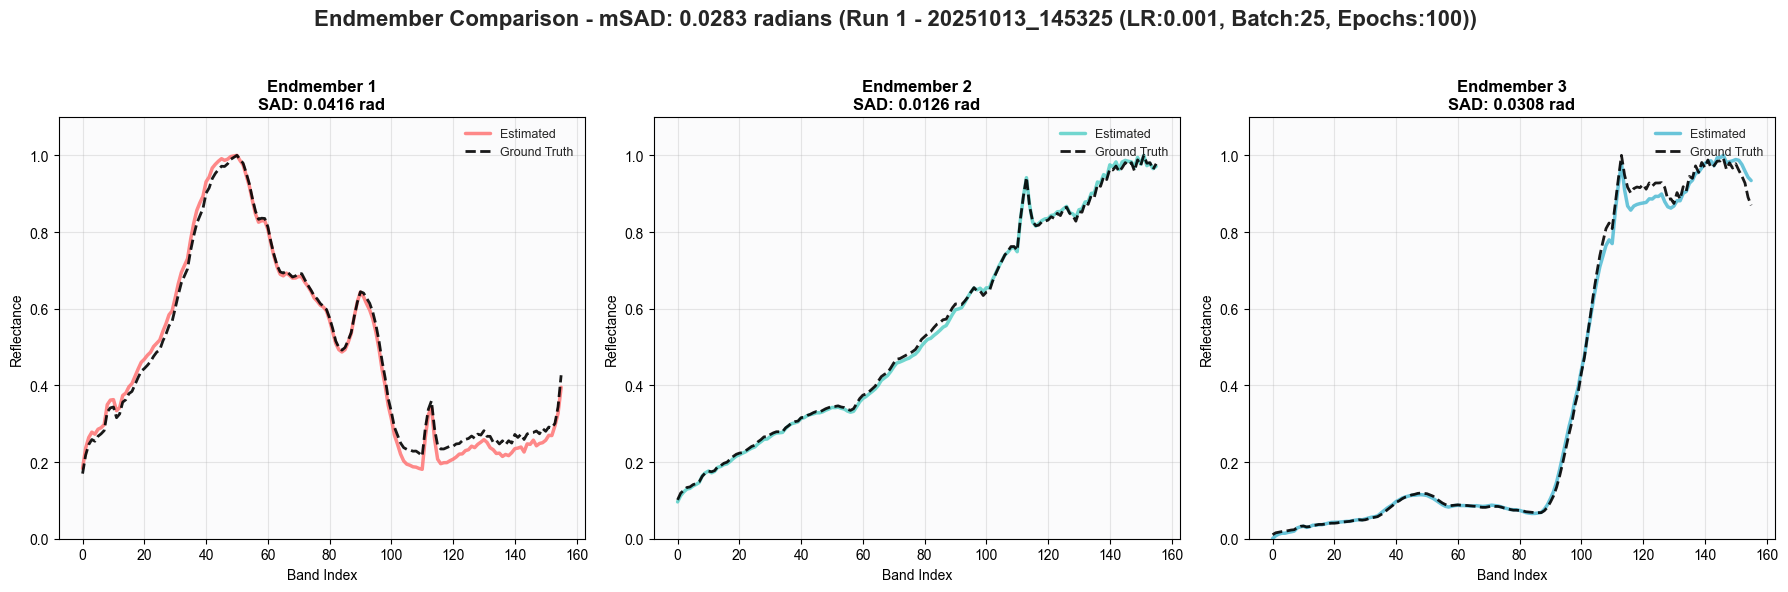

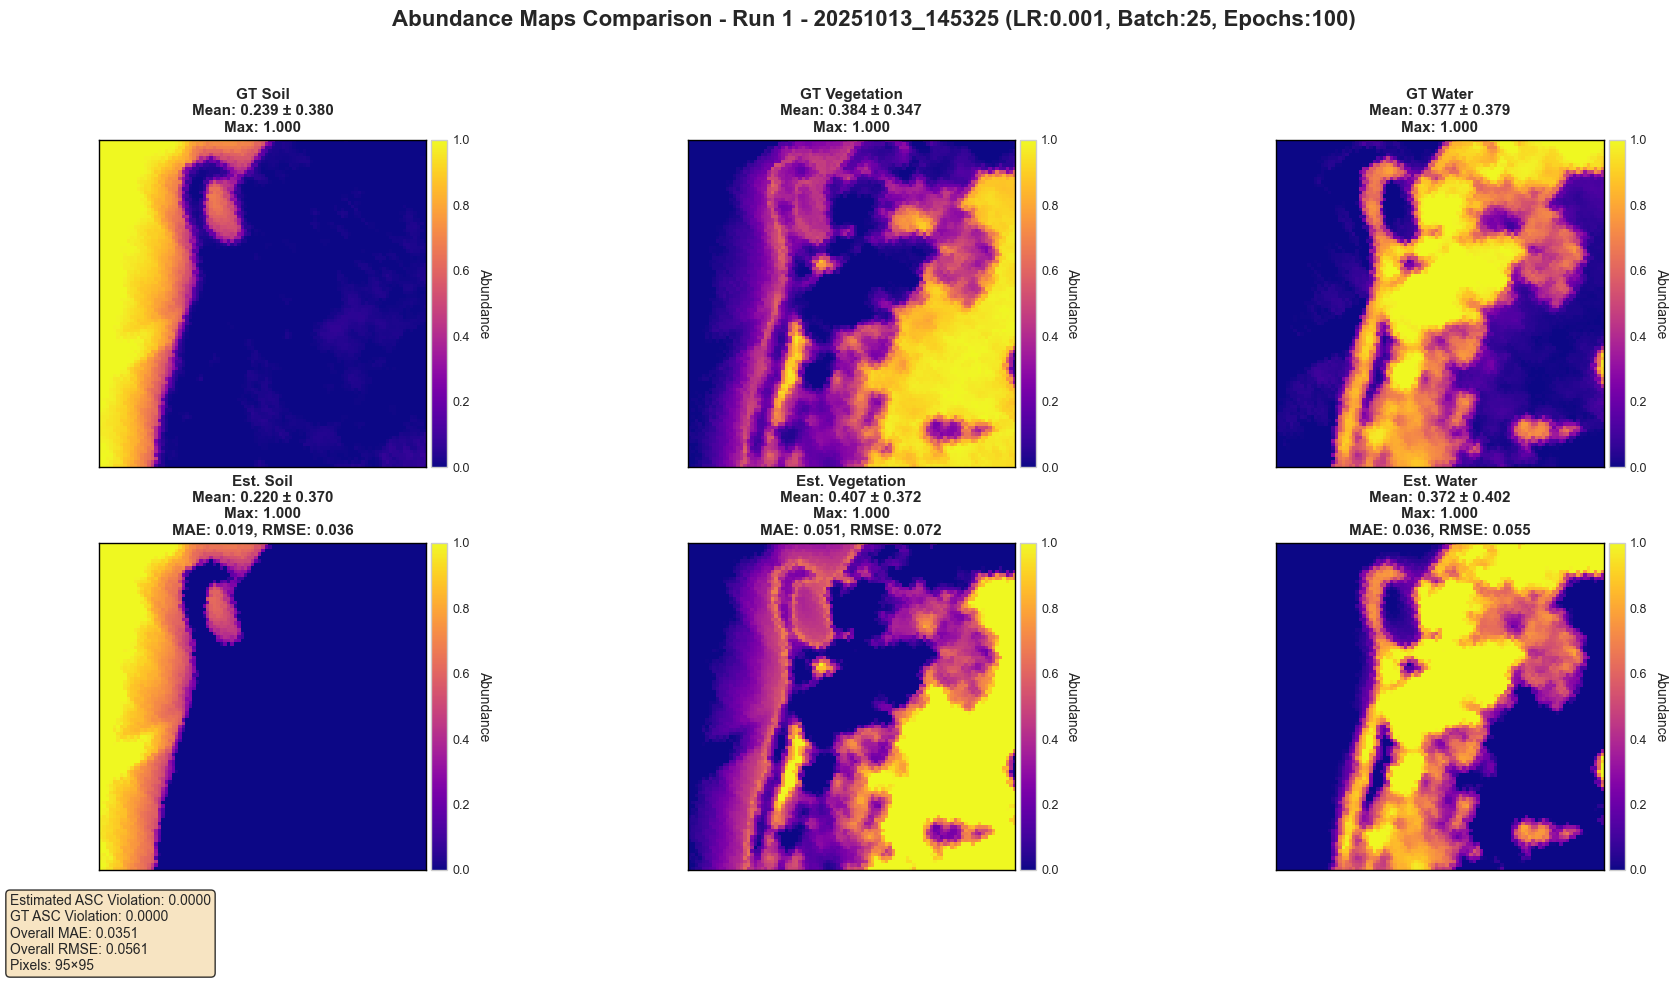

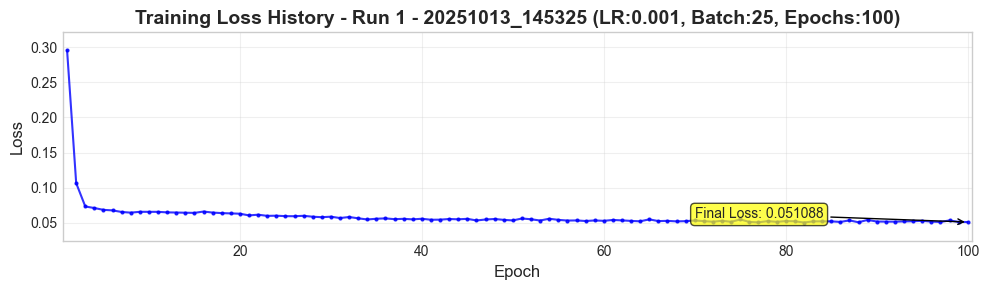


=== Run 2/2 ===
Parameters: LR=0.001, Batch=25, Epochs=100
Run timestamp: 20251013_145515
Total parameters: 5,391
Trainable parameters: 5,391
Training model...
Epoch 2/100, Loss: 0.299546, Beta: 0.0001
Epoch 4/100, Loss: 0.075797, Beta: 0.0001
Epoch 6/100, Loss: 0.069524, Beta: 0.0001
Epoch 8/100, Loss: 0.070037, Beta: 0.0001
Epoch 10/100, Loss: 0.065297, Beta: 0.0001
Epoch 12/100, Loss: 0.065929, Beta: 0.0001
Epoch 14/100, Loss: 0.066928, Beta: 0.0001
Epoch 16/100, Loss: 0.065401, Beta: 0.0001
Epoch 18/100, Loss: 0.065069, Beta: 0.0001
Epoch 20/100, Loss: 0.064267, Beta: 0.0001
Epoch 22/100, Loss: 0.064743, Beta: 0.0001
Epoch 24/100, Loss: 0.062991, Beta: 0.0001
Epoch 26/100, Loss: 0.063375, Beta: 0.0001
Epoch 28/100, Loss: 0.063657, Beta: 0.0001
Epoch 30/100, Loss: 0.063961, Beta: 0.0001
Epoch 32/100, Loss: 0.067032, Beta: 0.0001
Epoch 34/100, Loss: 0.064132, Beta: 0.0001
Epoch 36/100, Loss: 0.070580, Beta: 0.0001
Epoch 38/100, Loss: 0.064277, Beta: 0.0001
Epoch 40/100, Loss: 0.0628

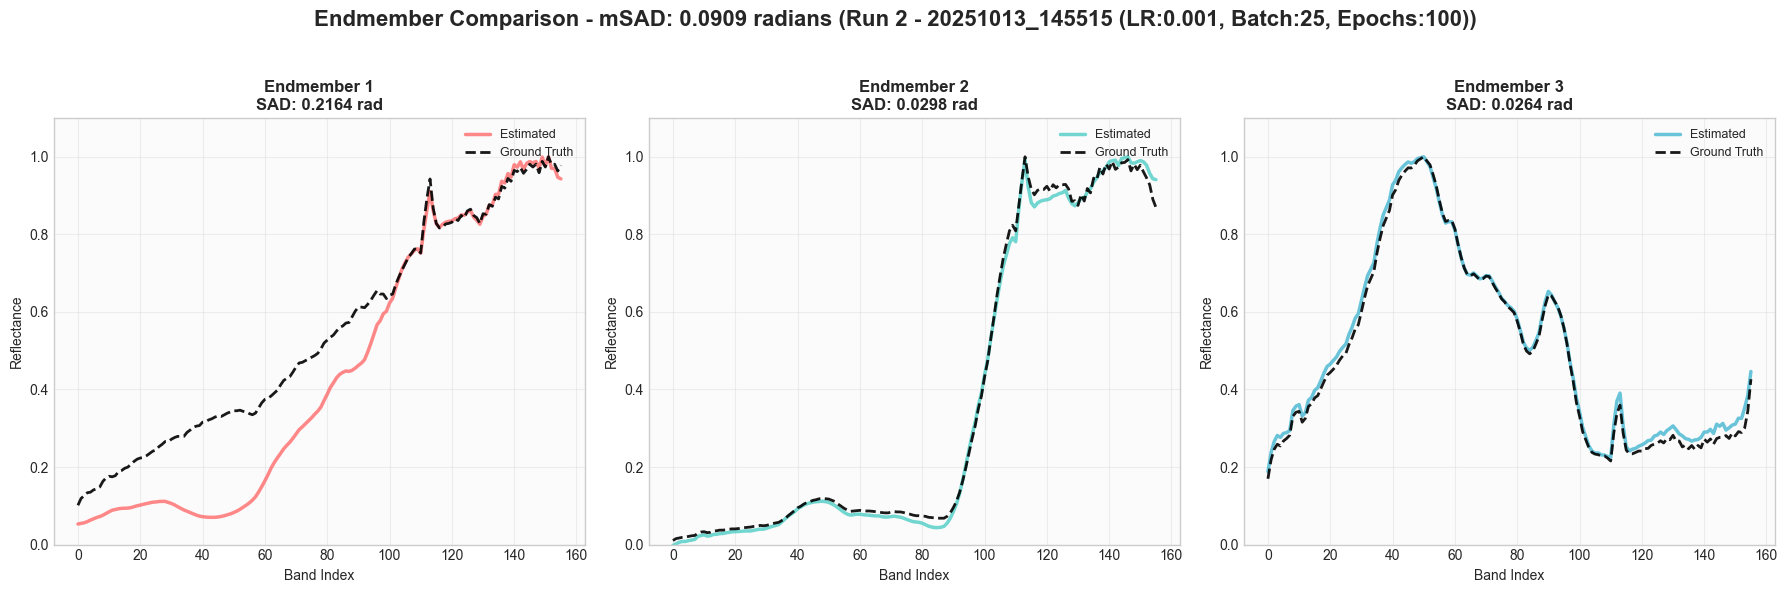

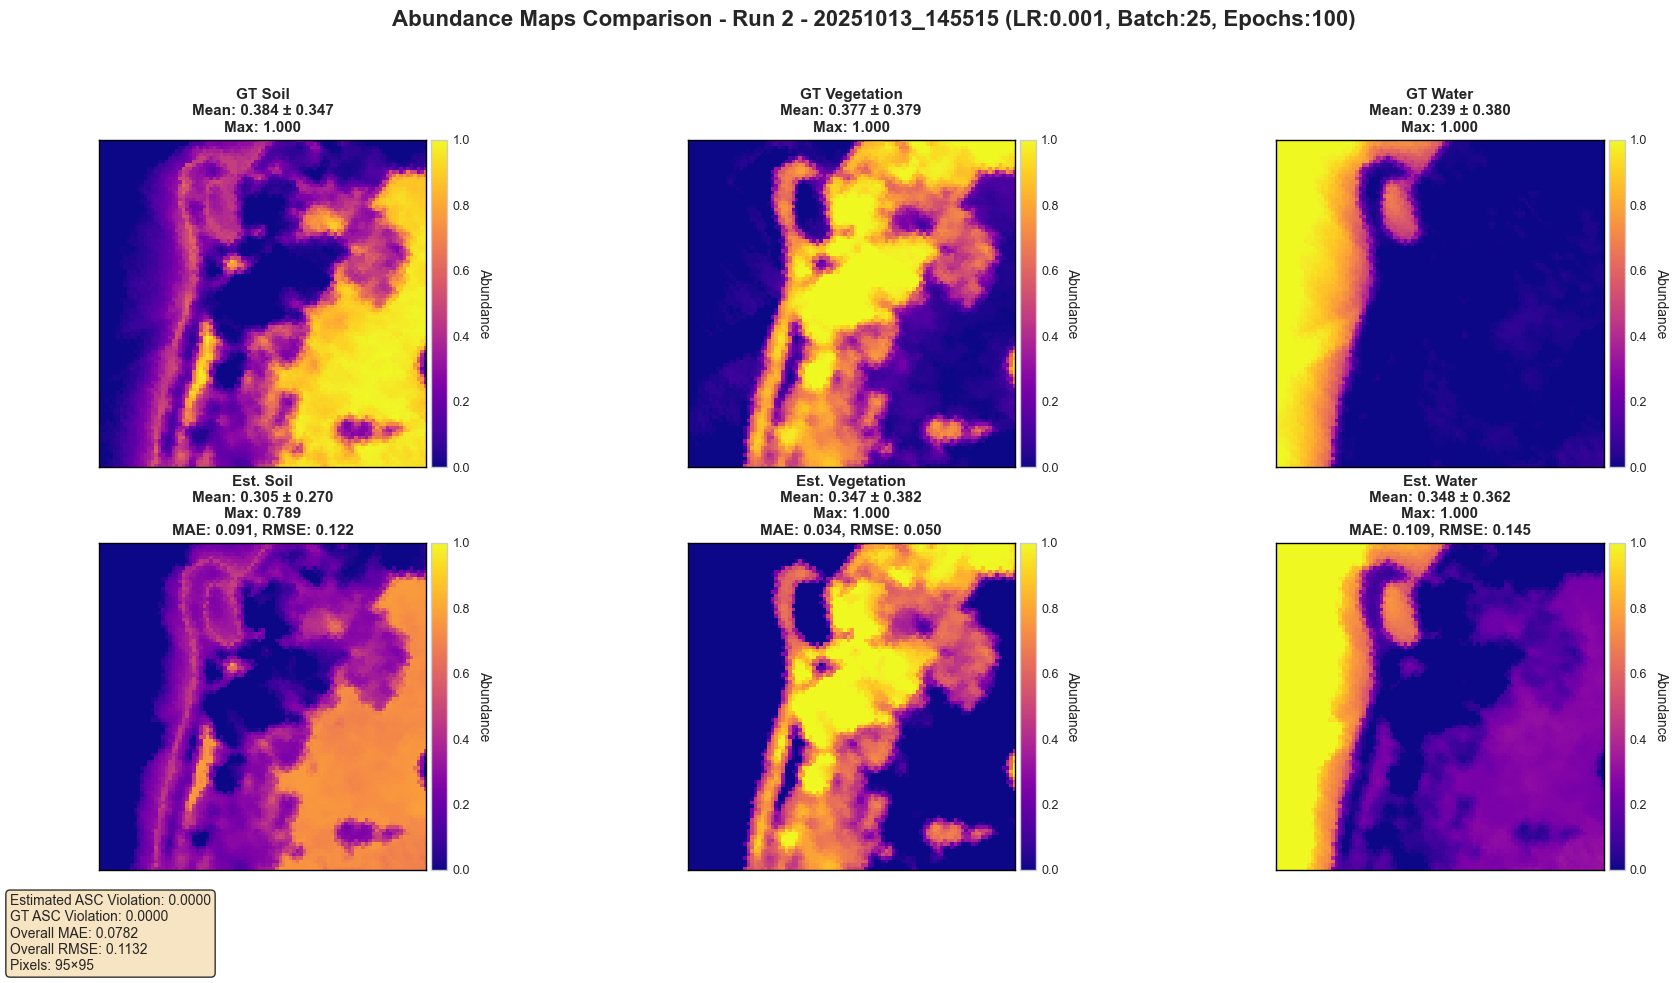

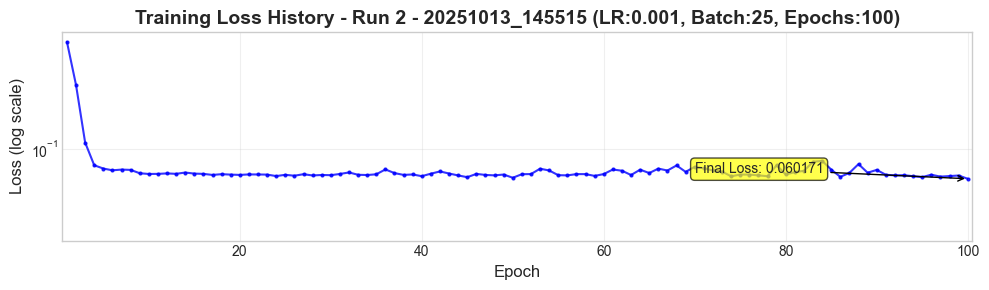


Experimental session 20251013_145325 completed!


In [2]:
dataset_path = "./Datasets/Samson.mat"

# To run a new set of experiments:
run_experiments()

Loaded results from: DAEU_Samson_run1_20251013_142101_lr0.001_bs25_ep10.mat
Run details:
  - num_endmembers: 3
  - num_spectra: 9025
  - n_bands: 156
  - learning_rate: 0.001
  - batch_size: 25
  - epochs: 10
  - beta: 0.01
  - run_number: 1
  - loss_type: SADLoss
  - lr: 0.001
  - timestamp: 20251013_142101
  - session_timestamp: 20251013_142101
  - optimizer_type: RMSprop
  - dataset: Samson
  - method: DAEU
  - training_time_seconds: 11.75626802444458
  - final_loss: 0.11950264421196195
Unmixing Performance Report:
  - Reconstruction_RMSE: 0.1381
  - aSAM_degrees: 2.4455
  - Abundance_aRMSE: 0.5775


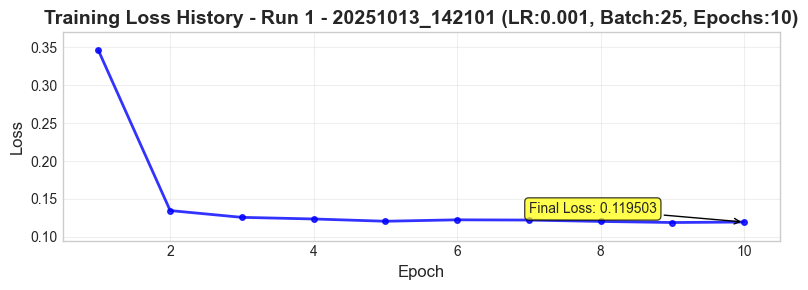

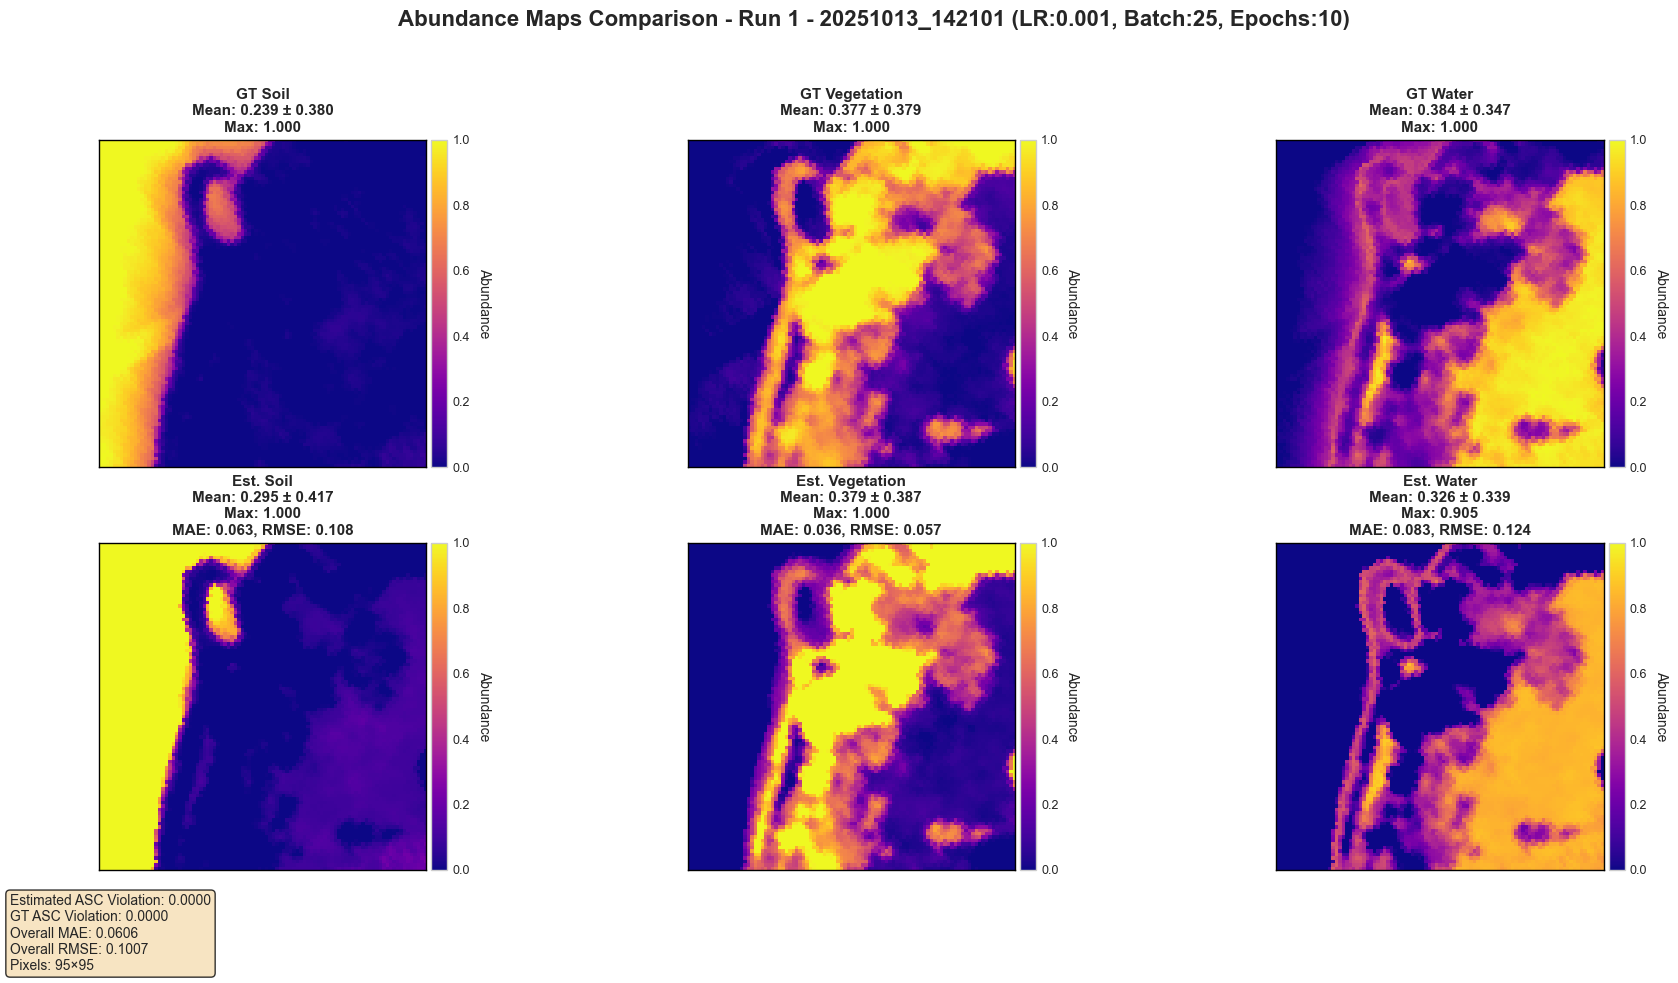

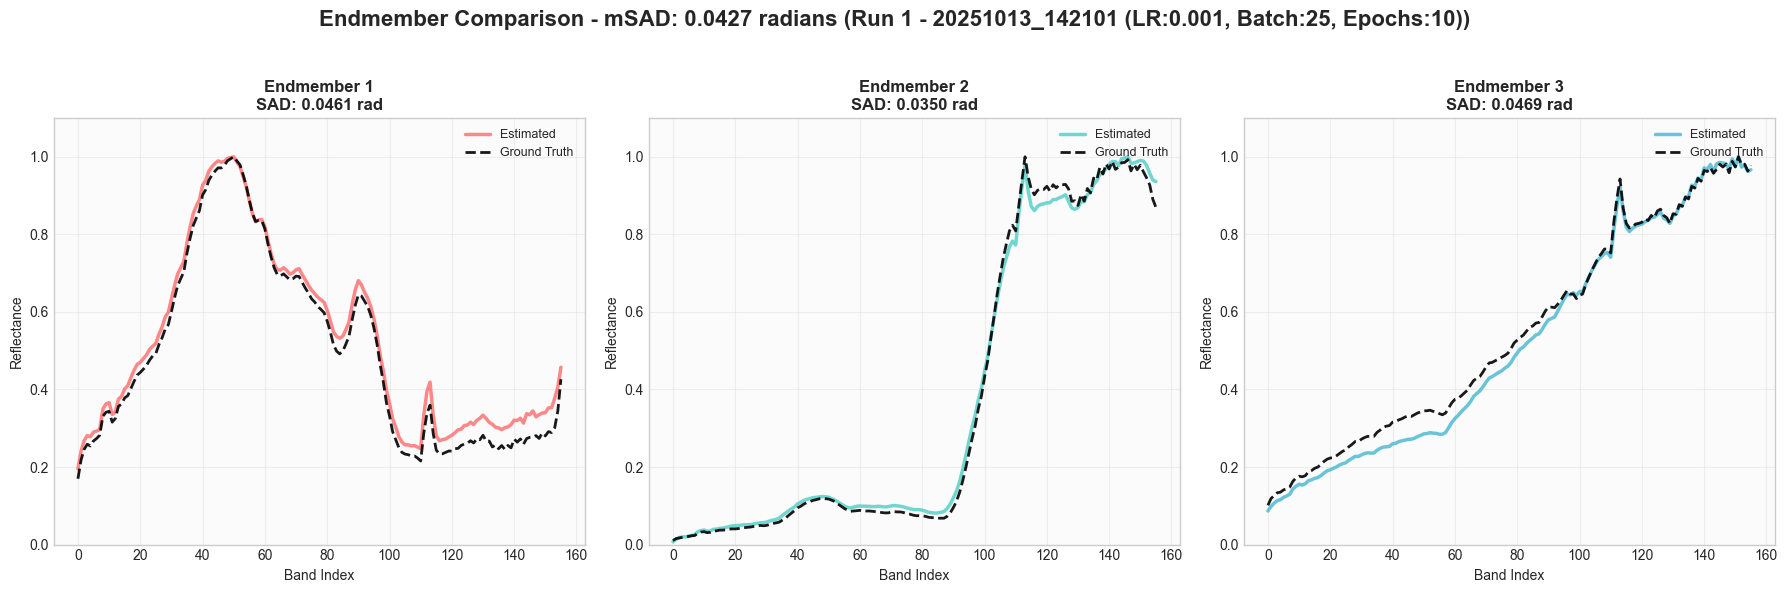

Loaded results from: DAEU_Samson_run2_20251013_142113_lr0.001_bs25_ep10.mat
Run details:
  - num_endmembers: 3
  - num_spectra: 9025
  - n_bands: 156
  - learning_rate: 0.001
  - batch_size: 25
  - epochs: 10
  - beta: 0.001
  - run_number: 2
  - loss_type: SADLoss
  - lr: 0.001
  - timestamp: 20251013_142113
  - session_timestamp: 20251013_142101
  - optimizer_type: RMSprop
  - dataset: Samson
  - method: DAEU
  - training_time_seconds: 11.667811155319214
  - final_loss: 0.07181703756431794
Unmixing Performance Report:
  - Reconstruction_RMSE: 0.1693
  - aSAM_degrees: 1.2332
  - Abundance_aRMSE: 0.5875


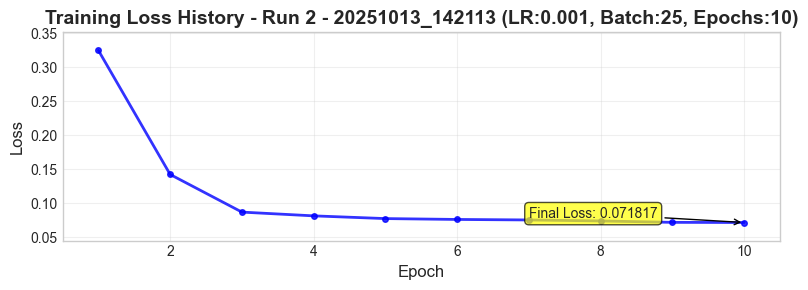

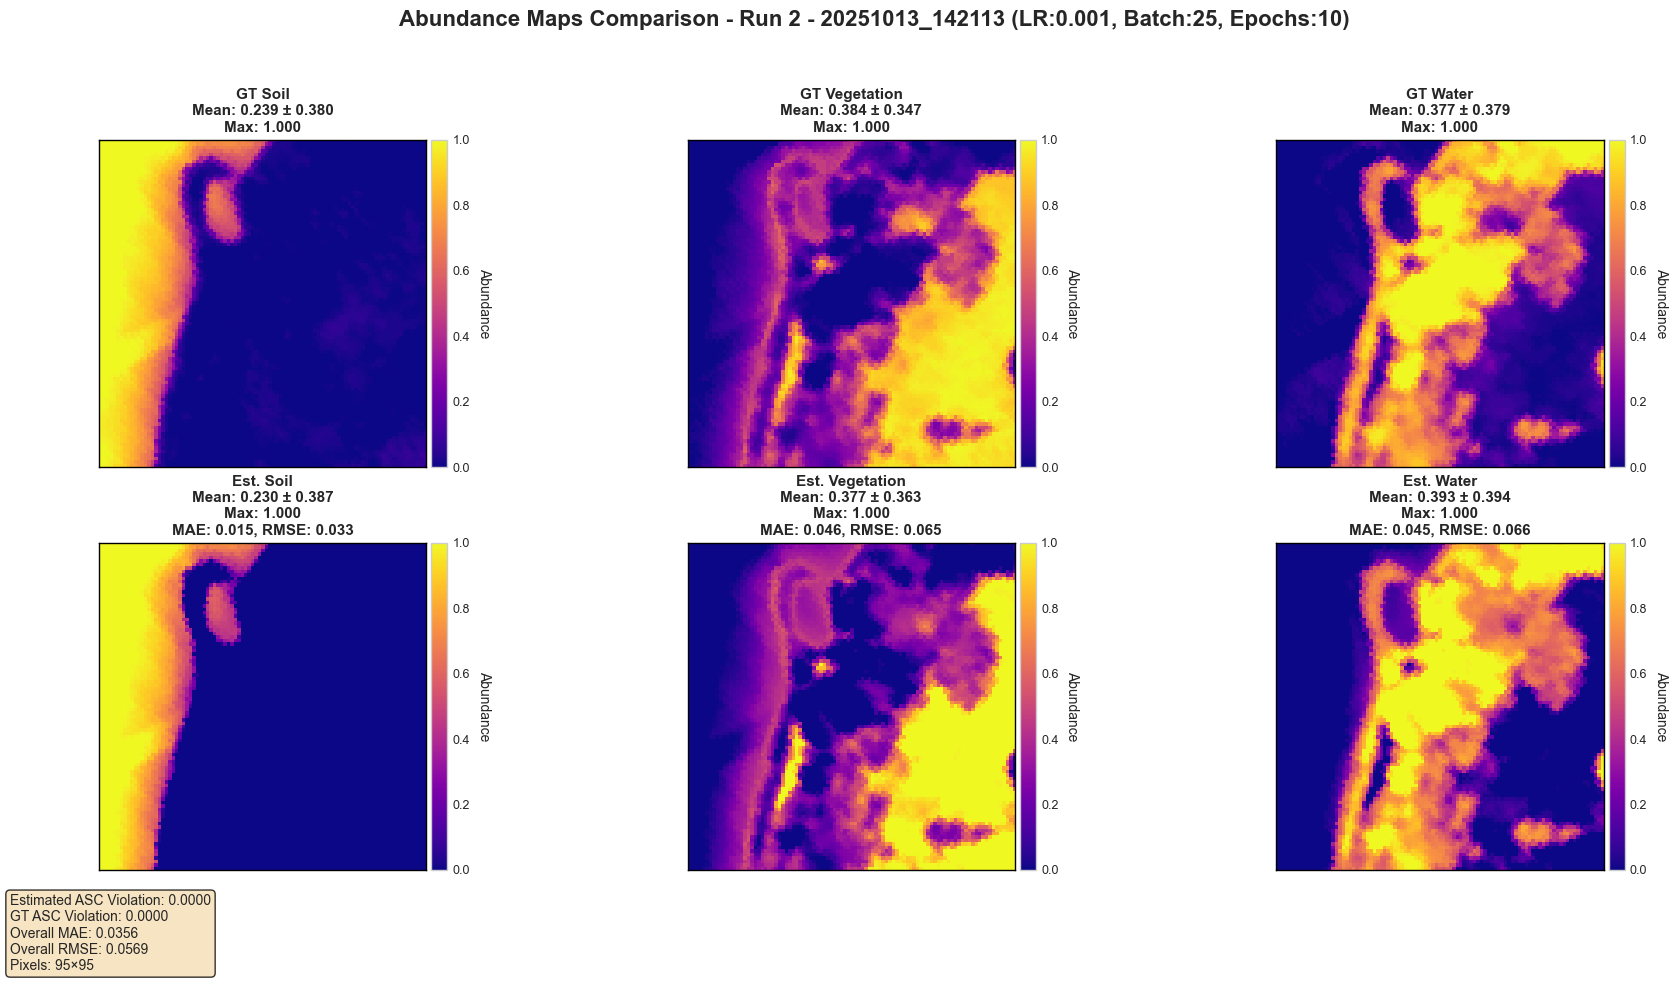

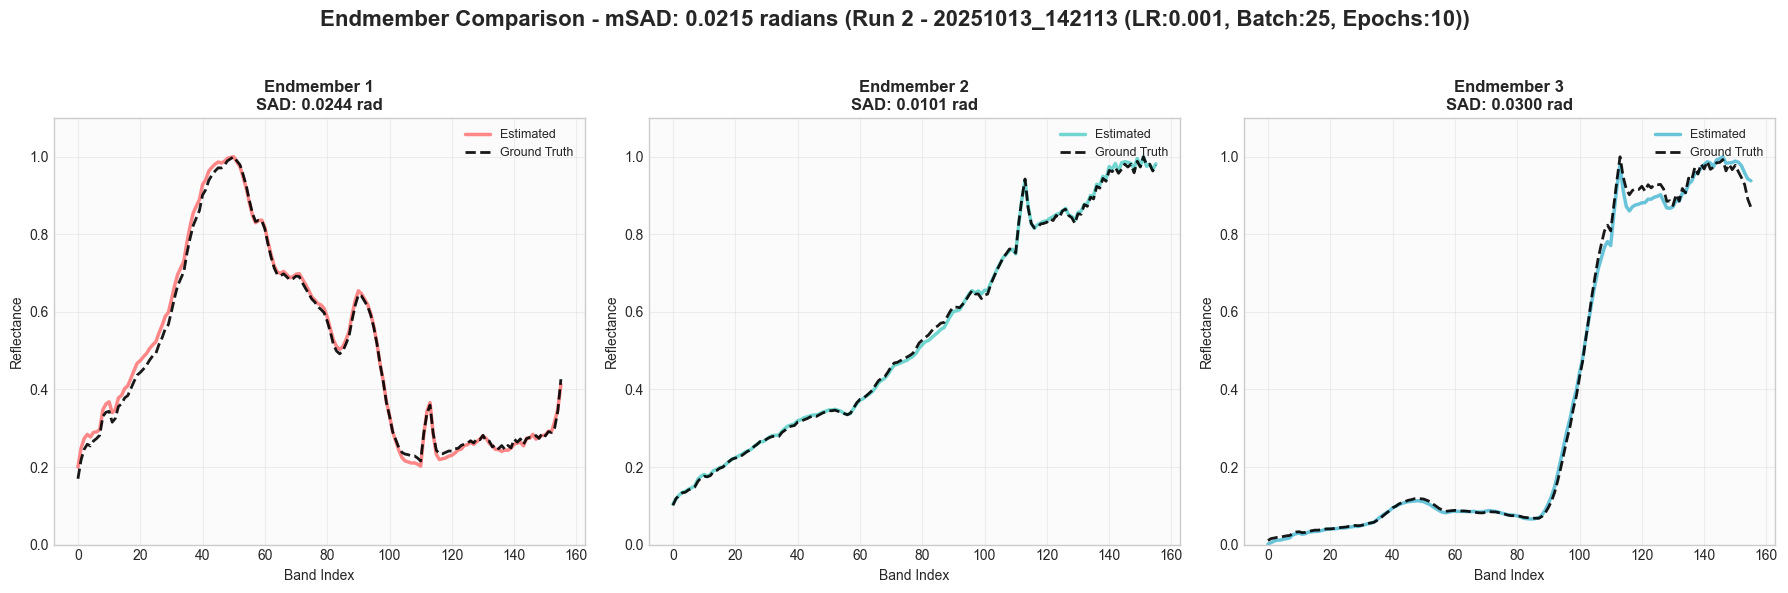

In [ ]:
runs_to_plot = [
    # AU
    # "./Results/DAEU/Samson/DAEU_Samson_run1_20251012_230920_lr0.001_bs25_ep10.mat",
    # "./Results/DAEU/Samson/DAEU_Samson_run2_20251012_230931_lr0.001_bs25_ep10.mat",
    # BVAE
    "./Results/DAEU/Samson/DAEU_Samson_run1_20251013_142101_lr0.001_bs25_ep10.mat",
    "./Results/DAEU/Samson/DAEU_Samson_run2_20251013_142113_lr0.001_bs25_ep10.mat",
]
for run_file in runs_to_plot:
    load_timestamped_run(
        run_file,
        dataset_path,
    )